Context: In this project, we'll explore how to use Natural Language Processing (NLP) techniques to identify common topics across a collection of 5 tech news articles.

Process involved: Data Cleaning, Vectorization(BoW method), LDA, Coherence score, and word cloud visualization.

Takeaways:
1. User and Password Security: Words like "user", "password", "hacker" and "database" indicate ongoing concerns about unauthorized access and the importance of securing user credentials to prevent breaches.
2. Data Breaches and Cyber Attacks: Terms such as "breach," "hacker," "site," "attack," and "system" reveal the persistent threat of cyber attacks targeting sensitive information.
3. Impact on Healthcare: Specific references to "patient," "medic," and "medical" data, These topics highlight the severe consequences that breaches can have on individuals' personal and medical privacy.

### $\color{blue}{\text{Initial Setups}}$

In [ ]:
# Standard Imports
import pandas as pd
import time
import re
import unicodedata
import matplotlib.pyplot as plt

# NLP Imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Gensim Imports
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("nlp_data.csv")
df.head(2)

Saving nlp_data.csv to nlp_data (3).csv


### $\color{blue}{\text{Part One: Clean Data}}$

In [ ]:
# Clean text
def clean_text(x):
  x=unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8')
  x=x.lower()
  x=re.sub(r"[^\w\s]"," ", x)
  x=re.sub('"\s+',' ',x).strip()
  return x

articles=df['data'].apply(clean_text)

# Remove stopwords and tokenize
extended_stopwords = set(stopwords.words('english')).union({'said', 'million', 'information'})
articles = articles.apply(lambda x: [word for word in word_tokenize(x) if word not in extended_stopwords])

# Stemming
ps=PorterStemmer()
articles=articles.apply(lambda tokens: [ps.stem(token) for token in tokens])

# Final output
print(articles.head(2))


0    [erson, info, 1, 5m, singhealth, patient, incl...
1    [quest, diagnost, say, 12, patient, may, finan...
Name: data, dtype: object


### $\color{blue}{\text{Part Two: Vectorization}}$

In [ ]:
# Convert the tokenized column to a list of lists of tokens
texts=articles.tolist()

# Create a Dictionary - a mapping of word IDs to words
dictionary=Dictionary(texts)

# Filter out extremes (remove too rare and too common words)
dictionary.filter_extremes(no_below=2, no_above=0.8)

# Create a Corpus - a list of bags of words
corpus = [dictionary.doc2bow(text) for text in texts]

print(f"Document-Term Matrix shape: ({len(corpus)}, {len(dictionary)})")

Document-Term Matrix shape: (5, 195)


### $\color{blue}{\text{Part Three: LDA}}$

In [ ]:
# Train LDA Model
num_topics=6
lda_model=LdaModel(corpus=corpus,
                   id2word=dictionary,
                   num_topics=num_topics,
                   random_state=42,
                   chunksize=100,
                   passes=10,
                   alpha='auto',
                   per_word_topics=True)

# Print the topics with their top 5 words
for idx,topic in lda_model.print_topics(num_words=5):
  print(f'Topic {idx+1}: {topic}')

Topic 1: 0.046*"first" + 0.040*"number" + 0.040*"site" + 0.037*"record" + 0.034*"real"
Topic 2: 0.008*"user" + 0.007*"password" + 0.007*"hacker" + 0.006*"use" + 0.006*"databas"
Topic 3: 0.070*"user" + 0.036*"hacker" + 0.027*"site" + 0.027*"breach" + 0.027*"compani"
Topic 4: 0.050*"patient" + 0.038*"stolen" + 0.034*"1" + 0.034*"juli" + 0.034*"attack"
Topic 5: 0.050*"password" + 0.043*"app" + 0.043*"expos" + 0.036*"user" + 0.036*"databas"
Topic 6: 0.034*"breach" + 0.034*"system" + 0.028*"file" + 0.028*"patient" + 0.028*"medic"


### $\color{blue}{\text{Part Four: Coherence Score}}$

In [ ]:
# Evaluate Coherence Score for 6 topics case
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.43039016769581934


### $\color{blue}{\text{Reference Step Only: Steps to Test Out the Best Fit of Number of Topics}}$

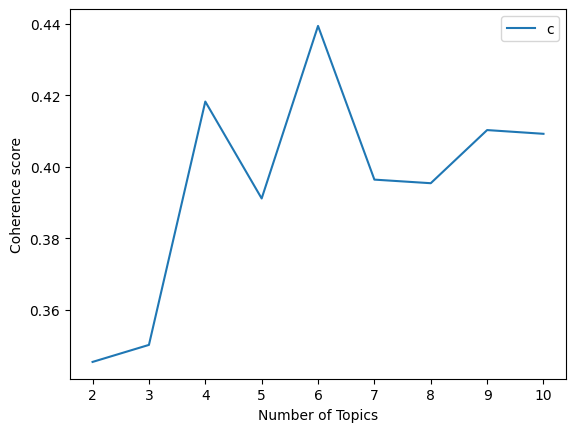

In [ ]:
# Steps to test out the best fit of number of topics (highest coherence score)
# Define the range for the number of topics
topic_range=range(2,11)
coherence_scores=[]

# Looop through each number of topics and evaluate coherence score
for num_topics in topic_range:
  # Train LDA Model
  lda_model=LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    random_state=42,
                    chunksize=100,
                    passes=10,
                    alpha=0.01,
                    per_word_topics=True)

  # Evaluate Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_scores.append(coherence_lda)

plt.plot(topic_range, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_scores"))
plt.show()

# Takeaways: 6 topics is the best choice per chart below.

### $\color{blue}{\text{Final Visual: Topic words frequency in word cloud}}$

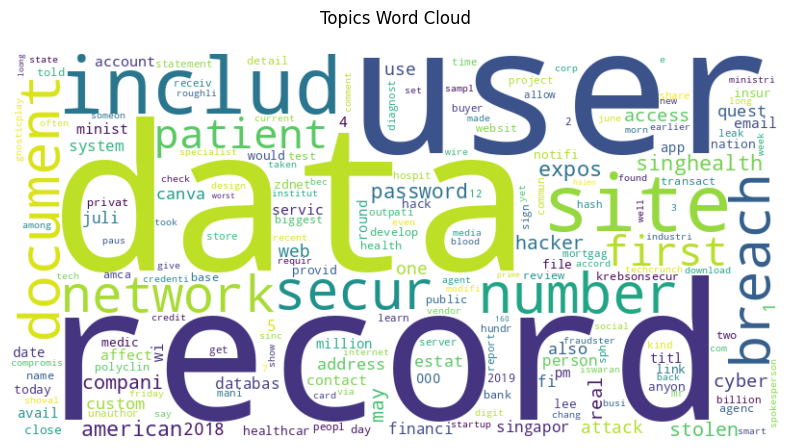

In [ ]:
# Generates and displays a word cloud from topic keywords.

# Flatten the list of keywords
all_keywords=[word for sublist in texts for word in sublist]

# Create a frequency dictionary
word_freq={}
for word in all_keywords:
  word_freq[word]=word_freq.get(word, 0)+1

# Generate and display the word cloud
wordcloud=WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()